In [1]:
  from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 0

## Import modules and utilities

In [2]:
import json
import pandas as pd
import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
# !pip install -Iv seaborn==0.11.0
import seaborn as sns
print(sns.__version__)
sns.set_style()
# from scipy.stats import pearsonr
# from scipy.stats import iqr

%cd '/content/drive/My Drive/Colab Notebooks/media-agenda'
%pwd 

import util
from util import DocType, Source, OptimalKClustersConfig
import senti_util
from termcolor import colored, cprint

%cd '/content/drive/My Drive/Colab Notebooks/media-agenda/plot'
%pwd 

0.11.0
/content/drive/.shortcut-targets-by-id/1jko4SIvsKFTxv155O0DV1wHZ_jS75VfX/Colab Notebooks/media-agenda
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/content/drive/.shortcut-targets-by-id/1jko4SIvsKFTxv155O0DV1wHZ_jS75VfX/Colab Notebooks/media-agenda/plot


'/content/drive/.shortcut-targets-by-id/1jko4SIvsKFTxv155O0DV1wHZ_jS75VfX/Colab Notebooks/media-agenda/plot'

## Load dataframe for analysis

In [7]:
start_year = 2009
end_year = 2017
start_datetime, end_datetime, start_datetime_str, end_datetime_str = util.get_start_end_datetime(start_year, end_year)
# df = senti_util.get_sentence_cluster_sentiment_df(start_year = start_year, end_year = end_year, 
#                                                   path = '/content/drive/My Drive/Colab Notebooks/media-agenda/data/sentence_cluster_sentiment_dict.json', verbose = True)

# load the dataframe
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/media-agenda/data/df_2009_to_2017_with_time_interval_indexing.csv')

# add 'bin_of_every_1_day' column
date_list = senti_util.get_date_list(start_datetime, end_datetime, freq = '1D')
date_df = pd.DataFrame({'bin_of_every_1_day': range(len(date_list)),
                        'date': date_list})
date_df['date'] = date_df['date'].dt.strftime('%Y-%m-%d')
df = df.merge(date_df, how = 'left', on = 'date')

df.head()

,Unnamed: 0,sentence_id,source,article_id,comment_id,posting_time,cluster,sentiw_sentiment,textblob_polarity,textblob_subjectivity,is_comment,date,month,year,bin_of_every_2_days,bin_of_every_3_days,bin_of_every_4_days,bin_of_every_5_days,bin_of_every_6_days,bin_of_every_7_days,bin_of_every_14_days,bin_of_every_28_days,bin_of_every_56_days,bin_of_every_1_day
0,0,12739,nytimes,101,-1,2009-01-11 00:00:00,1,-0.250000,-0.066667,0.600000,False,2009-01-11,1,2009,5,3,2,2,1,1,0,0,0,10
1,1,12721,nytimes,101,-1,2009-01-11 00:00:00,1,0.000000,0.083333,0.500000,False,2009-01-11,1,2009,5,3,2,2,1,1,0,0,0,10
2,2,12722,nytimes,101,-1,2009-01-11 00:00:00,6,0.166667,-0.066667,0.533333,False,2009-01-11,1,2009,5,3,2,2,1,1,0,0,0,10
3,3,12726,nytimes,101,-1,2009-01-11 00:00:00,3,-0.041667,-0.133333,0.450000,False,2009-01-11,1,2009,5,3,2,2,1,1,0,0,0,10
4,4,12727,nytimes,101,-1,2009-01-11 00:00:00,6,0.375000,0.250000,0.300000,False,2009-01-11,1,2009,5,3,2,2,1,1,0,0,0,10


# Part 1

## plot distribution of sentiment in different time windows

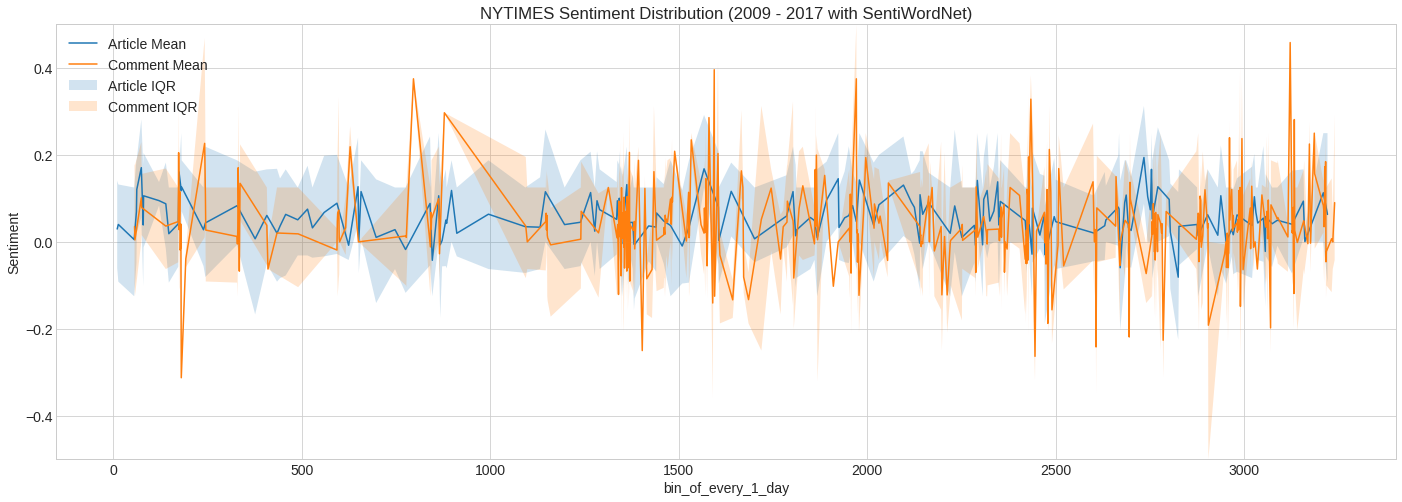

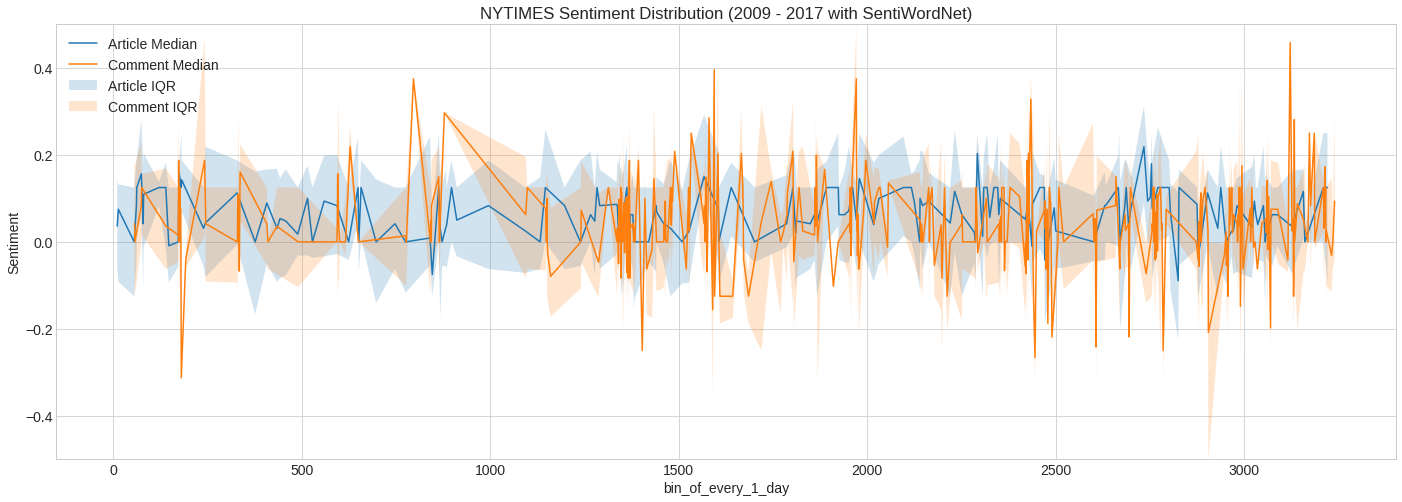

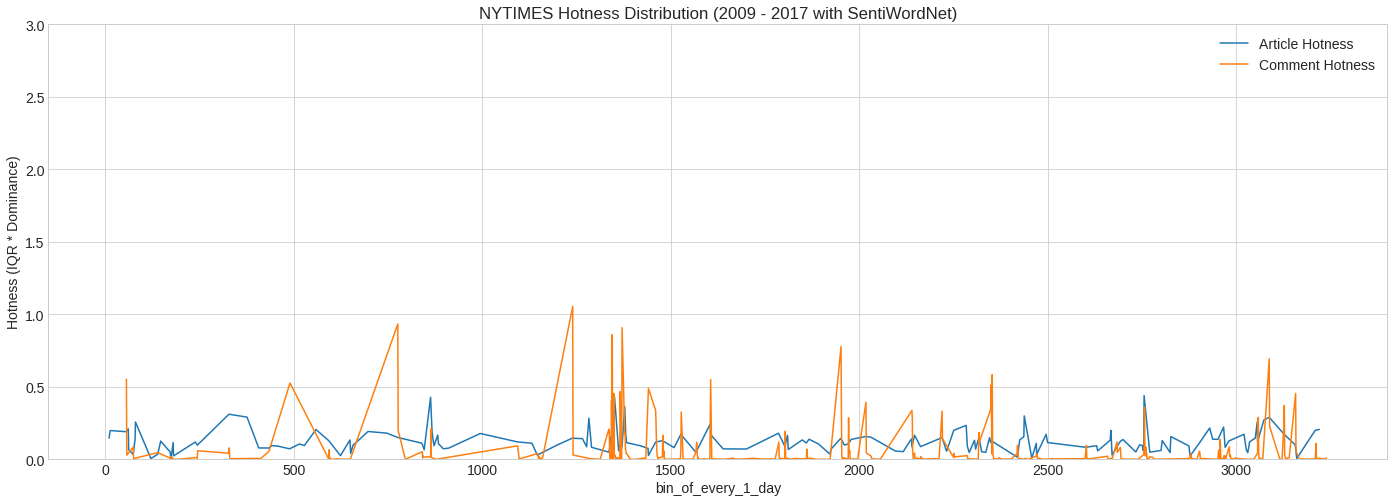

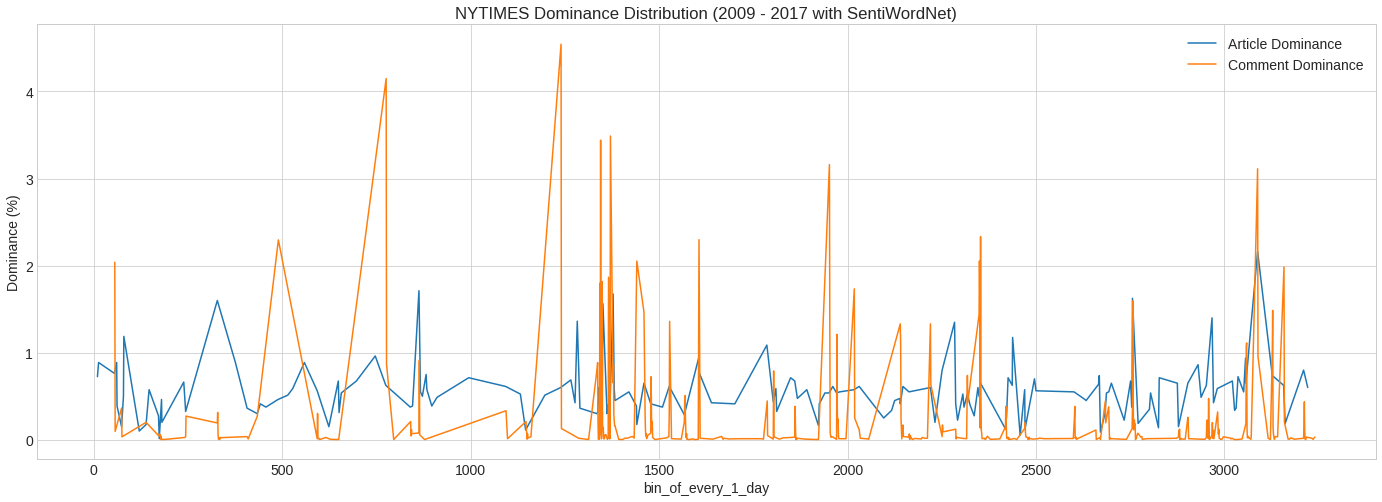

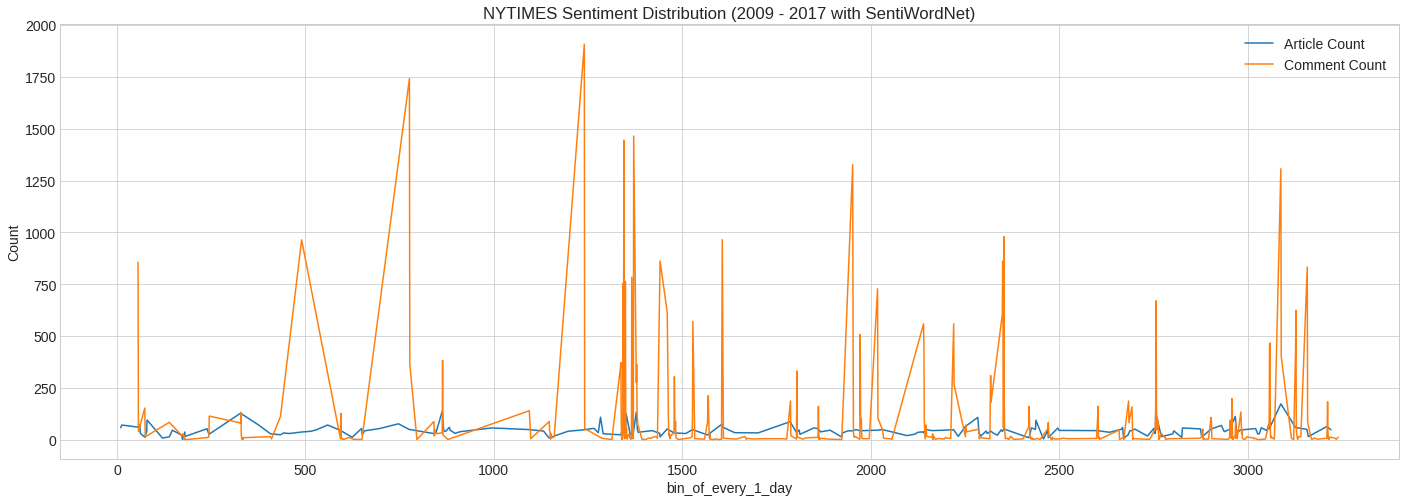

In [8]:
def plot(source = Source, is_textblob = False, bin = 'bin_of_every_14_days', by = 'mean'):
  if source == Source.SPIEGEL:
    senti_choice = 'Textblob-de' if is_textblob else 'SentiWS'
  else:
    senti_choice = 'Textblob' if is_textblob else 'SentiWordNet'
    

  article_df = df[(df.source == source) & (df.is_comment == False)]
  comment_df = df[(df.source == source) & (df.is_comment == True)]

  article_stat_df = senti_util.get_sentiment_stat(article_df, is_textblob, bin)
  comment_stat_df = senti_util.get_sentiment_stat(comment_df, is_textblob, bin)


  plt.figure(figsize = (24, 8))
  plt.style.use('seaborn-whitegrid')
  plt.rcParams.update({'font.size': 14})
  
  if by == 'hotness':
    g = sns.lineplot(data = article_stat_df, x = bin, y = 'hotness', label = 'Article Hotness')
    sns.lineplot(data = comment_stat_df, x = bin, y = 'hotness', label = 'Comment Hotness')
  elif by == 'mean':
    g = sns.lineplot(data = article_stat_df, x = bin, y = 'mean', label = 'Article Mean')
    sns.lineplot(data = comment_stat_df, x = bin, y = 'mean', label = 'Comment Mean')
  elif by == 'median':
    g = sns.lineplot(data = article_stat_df, x = bin, y = 'median', label = 'Article Median')
    sns.lineplot(data = comment_stat_df, x = bin, y = 'median', label = 'Comment Median')
  elif by == 'groupby_count':
     g = sns.lineplot(data = article_stat_df, x = bin, y = 'groupby_count', label = 'Article Count')
     sns.lineplot(data = comment_stat_df, x = bin, y = 'groupby_count', label = 'Comment Count')
  elif by == 'dominance':
     g = sns.lineplot(data = article_stat_df, x = bin, y = 'dominance', label = 'Article Dominance')
     sns.lineplot(data = comment_stat_df, x = bin, y = 'dominance', label = 'Comment Dominance')

  if by == 'hotness':
    g.set(xlabel = bin, ylabel = 'Hotness (IQR * Dominance)')
    g.set_title('{} Hotness Distribution ({} - {} with {})'.format(str.upper(source), start_year, end_year, senti_choice))
    plt.ylim(0, 3)
  elif by == 'groupby_count':
    g.set(xlabel = bin, ylabel = 'Count')
    g.set_title('{} Sentiment Distribution ({} - {} with {})'.format(str.upper(source), start_year, end_year, senti_choice))
  elif by == 'dominance':
    g.set(xlabel = bin, ylabel = 'Dominance (%)')
    g.set_title('{} Dominance Distribution ({} - {} with {})'.format(str.upper(source), start_year, end_year, senti_choice))
  else:
    g.fill_between(x = article_stat_df[bin], y1 = article_stat_df.third_quantile, y2 = article_stat_df.first_quantile, alpha = 0.2, label = 'Article IQR')
    g.fill_between(x = comment_stat_df[bin], y1 = comment_stat_df.third_quantile, y2 = comment_stat_df.first_quantile, alpha = 0.2, label = 'Comment IQR')
    g.set(xlabel = bin, ylabel = 'Sentiment')
    g.set_title('{} Sentiment Distribution ({} - {} with {})'.format(str.upper(source), start_year, end_year, senti_choice))
    plt.ylim(-0.5, 0.5)
  
  plt.legend()
  plt.show()

bin = 'bin_of_every_1_day'
# bin = 'bin_of_every_3_days'
# bin = 'bin_of_every_4_days'
# bin = 'bin_of_every_7_days'
# bin = 'bin_of_every_14_days'
# bin = 'bin_of_every_28_days'
# bin = 'bin_of_every_56_days'

plot(source = Source.NYTIMES, is_textblob = False, bin = bin, by = 'mean')
plot(source = Source.NYTIMES, is_textblob = False, bin = bin, by = 'median')
plot(source = Source.NYTIMES, is_textblob = False, bin = bin, by = 'hotness')
plot(source = Source.NYTIMES, is_textblob = False, bin = bin, by = 'dominance')
plot(source = Source.NYTIMES, is_textblob = False, bin = bin, by = 'groupby_count')

# plot(source = Source.NYTIMES, is_textblob = True, bin = bin, by = 'mean')
# plot(source = Source.NYTIMES, is_textblob = True, bin = bin, by = 'median')
# plot(source = Source.NYTIMES, is_textblob = True, bin = bin, by = 'hotness')
# plot(source = Source.NYTIMES, is_textblob = True, bin = bin, by = 'dominance')
# plot(source = Source.NYTIMES, is_textblob = True, bin = bin, by = 'groupby_count')
